<a href="https://colab.research.google.com/github/open-mmlab/mmsegmentation/blob/main/demo/MMSegmentation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Finetune a semantic segmentation model on a new dataset

To finetune on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

We need to convert the annotation into semantic map format as an image.

In [1]:
import torch, mmseg, mmcv, mmengine, os, shutil, numpy as np
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt

In [ ]:
# In the folder Dataset, take all the files in the subfolders and put them in the main folder
import os
import shutil

# Get the current working directory
cwd = os.getcwd()

# Get the path to the dataset
dataset_path = os.path.join(cwd, "Dataset/Labels/")

# Get the path to the main folder
main_folder_path = dataset_path

# Get the path to the subfolders
subfolders_path_switzerland = os.listdir(dataset_path)

# For each subfolder
for subfolder_switzerland in subfolders_path_switzerland:

    # Get the path to the subfolders
    subfolders_path_stadium = os.listdir(os.path.join(dataset_path, subfolder_switzerland))

    # For each subfolder
    for subfolder_stadium in subfolders_path_stadium:

        # Get the path to the subfolders
        subfolders_path_match = os.listdir(os.path.join(dataset_path, subfolder_switzerland, subfolder_stadium))

        # For each subfolder
        for subfolder_match in subfolders_path_match:
            # Get the path to the subfolder
            subfolder_path = os.path.join(dataset_path, subfolder_switzerland, subfolder_stadium, subfolder_match)
            # Get the files in the subfolder
            files = os.listdir(subfolder_path)
            # For each file
            for file in files:

                # Rename the file by appening the name of the subfolders
                file_new_name = subfolder_stadium + "_" + subfolder_match + "_" + file

                # Copy the file in the main folder
                shutil.copy(os.path.join(subfolder_path, file), os.path.join(main_folder_path, file_new_name))
                

In [2]:
# define dataset root and directory for images and annotations
data_root = 'Dataset'
img_dir = 'Images'
ann_dir = 'Labels'

# Below if an example of the classes and the palette for the segmentation of a dataset
# classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')
# palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
#            [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]
# Below description of the classes and the palette for the segmentation of my dataset
#                              R-G-B
# ---------------------------------------------------------
# Outside billboards

#     1.                    000-000-000  (black)

# ---------------------------------------------------------
# Inside billboards

#     2. Billboard          255-255-255  (white)

#     3. Field player       255-000-000  (red)
#     4. Goalkeeper         000-255-000  (green)
#     5. Referee            000-000-255  (blue)
#     6. Assistant referee  255-255-000  (yellow)
#     7. Other human        255-000-255  (pink)

#     8. Ball               000-255-255  (turquoise)

#     9. Goal post          128-000-000  (dark red)
#    10. Goal net           000-128-000  (dark green)
#    12. Net post           000-000-128  (dark blue)
#    13. Cross-bar          064-064-064  (dark gray)

#    14. Corner flag        128-128-000  (dark yellow)
#    15. Assistant flag     128-000-128  (purple)

#    16. Microphone         000-128-128  (dark turquoise)
#    17. Camera             255-128-000  (orange)
   
#    18. Other object       192-192-192  (light gray)
  
#    19. Don't care         128-128-128  (gray)
# ---------------------------------------------------------
# Define the classes and the palette for the segmentation of my dataset
old_classes = ('Outside billboards', 'Billboard', 'Field player', 'Goalkeeper', 'Referee', 'Assistant referee', 'Other human', 'Ball', 'Goal post', 'Goal net', 'Net post', 'Cross-bar', 'Corner flag', 'Assistant flag', 'Microphone', 'Camera', 'Other object', 'Don\'t care')
old_palette = [[0, 0, 0], [255, 255, 255], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [128, 0, 0], [0, 128, 0], [0, 0, 128], [64, 64, 64], [128, 128, 0], [128, 0, 128], [0, 128, 128], [255, 128, 0], [192, 192, 192], [128, 128, 128]]
old_palette_dict = {tuple(p): i for i, p in enumerate(old_palette)}
old_classes_dict = {i: c for i, c in enumerate(old_classes)}

# # We only want two classes: the billboards and the rest
# classes = ('Billboards', 'non_billboards')
# palette = [[0, 255, 0], [255, 0, 0]]

In [3]:
old_classes_dict

{0: 'Outside billboards',
 1: 'Billboard',
 2: 'Field player',
 3: 'Goalkeeper',
 4: 'Referee',
 5: 'Assistant referee',
 6: 'Other human',
 7: 'Ball',
 8: 'Goal post',
 9: 'Goal net',
 10: 'Net post',
 11: 'Cross-bar',
 12: 'Corner flag',
 13: 'Assistant flag',
 14: 'Microphone',
 15: 'Camera',
 16: 'Other object',
 17: "Don't care"}

In [4]:
old_palette_dict

{(0, 0, 0): 0,
 (255, 255, 255): 1,
 (255, 0, 0): 2,
 (0, 255, 0): 3,
 (0, 0, 255): 4,
 (255, 255, 0): 5,
 (255, 0, 255): 6,
 (0, 255, 255): 7,
 (128, 0, 0): 8,
 (0, 128, 0): 9,
 (0, 0, 128): 10,
 (64, 64, 64): 11,
 (128, 128, 0): 12,
 (128, 0, 128): 13,
 (0, 128, 128): 14,
 (255, 128, 0): 15,
 (192, 192, 192): 16,
 (128, 128, 128): 17}

In [ ]:
from tqdm import tqdm
# For all the annotation images, change the pixels that are not white to black

all_ann_files = os.listdir(os.path.join(data_root, ann_dir))

def convert_ann_to_binary(ann_file_list):
    for file in tqdm(ann_file_list):
        self_check = True
        # Open the image
        ann = Image.open(os.path.join(data_root, ann_dir, file))
        # Get the pixels
        pixels = ann.load()
        # For each pixel
        for i in range(ann.size[0]):
            for j in range(ann.size[1]):
                # If the pixel is not white
                if pixels[i, j] != (255, 255, 255, 255) and pixels[i, j] != (255, 255, 255):
                    # Change the pixel to black
                    pixels[i, j] = (0, 0, 0, 255)
                else:
                    self_check = False
        if self_check:
            print("Error !!! File : " + file + " is all black")
        # Save the image
        ann.save(os.path.join(data_root, ann_dir, file))
    
from multiprocessing import Pool
import time
import numpy as np
from PIL import Image

# Define the number of processes
num_processes = 16

# Split the list of files in num_processes sublists
all_ann_files_split = np.array_split(all_ann_files, num_processes)

# Create the pool of processes
pool = Pool(processes=num_processes)

# Start the processes
pool.map(convert_ann_to_binary, all_ann_files_split)

# Close the processes
pool.close()

# Join the processes
pool.join()

All the files for which there was an error should be normal since there are no billboards in the images.

In [ ]:
all_ann_files = os.listdir(os.path.join(data_root, ann_dir))

# All the annotation images have a name that contains 'gt' and needs to be changed to 'in'
for file in tqdm(all_ann_files):
    # If the name contains 'gt'
    if 'gt' in file:
        # Change the name
        os.rename(os.path.join(data_root, ann_dir, file), os.path.join(data_root, ann_dir, file.replace('gt', 'in'))) 

In [ ]:
import os, numpy as np
ann_path = os.path.join(data_root, ann_dir, 'Stadium_1_Match_1_in_1fps_0042.png')
img = Image.open(ann_path)
print(img.size)
# Create a numpy array from the image
img_np = np.array(img, dtype=np.object_)
print(img_np.shape)
print(img_np[0,0,:].shape)
print(img_np[0,0,:3])
# Convert the numpy array to a 2D numpy array by changing each value of the third dimension by an integer given by old_palette_dict
img_np_2D = np.zeros((img_np.shape[0], img_np.shape[1]), dtype=np.uint8)
for i in range(img_np.shape[0]):
    for j in range(img_np.shape[1]):
        img_np_2D[i, j] = old_palette_dict[tuple(img_np[i, j, :3])]
print(img_np_2D.shape)
print(img_np_2D[0, 0])

seg_img = Image.fromarray(img_np_2D).convert('P')
seg_img.putpalette(np.array(old_palette, dtype=np.uint8))
plt.imshow(np.array(seg_img.convert('RGB')))
plt.show()

In [ ]:
import os, numpy as np
from tqdm import tqdm
from PIL import Image

# Change all the annotation images to 2D images with palette

all_ann_files = os.listdir(os.path.join(data_root, ann_dir))

def convert_ann_to_2D(ann_file_list):
    for file in tqdm(ann_file_list):
        # Open the image
        ann = Image.open(os.path.join(data_root, ann_dir, file))
        # Create a numpy array from the image
        ann_np = np.array(ann)
        # Convert the numpy array to a 2D numpy array by changing each value of the third dimension by an integer given by old_palette_dict
        ann_np_2D = np.zeros((ann_np.shape[0], ann_np.shape[1]), dtype=np.uint8)
        for i in range(ann_np.shape[0]):
            for j in range(ann_np.shape[1]):
                ann_np_2D[i, j] = old_palette_dict[tuple(ann_np[i, j, :3])]
        # Create the image from the numpy array
        seg_img = Image.fromarray(ann_np_2D).convert('P')
        # Add the palette to the image
        seg_img.putpalette(np.array(old_palette, dtype=np.uint8))
        # Save the image
        seg_img.save(os.path.join(data_root, ann_dir, file))

from multiprocessing import Pool
import time
import numpy as np
from PIL import Image

# Define the number of processes
num_processes = 16

# Split the list of files in num_processes sublists
all_ann_files_split = np.array_split(all_ann_files, num_processes)

# Create the pool of processes
pool = Pool(processes=num_processes)

# Start the processes
pool.map(convert_ann_to_2D, all_ann_files_split)

# Close the processes
pool.close()

# Join the processes
pool.join()

In [ ]:
# Check if all the annotation images are 2D images with palette
all_ann_files = os.listdir(os.path.join(data_root, ann_dir))

non3d_files = []

for file in tqdm(all_ann_files):
    # Open the image
    ann = Image.open(os.path.join(data_root, ann_dir, file))
    # Create a numpy array from the image
    ann_np = np.array(ann, dtype=np.object_)
    # If the numpy array is not a 2D numpy array
    if len(ann_np.shape) != 2:
        # Add the file to the list
        non3d_files.append(file)
        print(ann_np.shape)

In [ ]:
convert_ann_to_2D(non3d_files)

In [ ]:
# Check if for all images in img_dir there is an image in ann_dir with the same name
all_img_files = os.listdir(os.path.join(data_root, img_dir))
all_ann_files = os.listdir(os.path.join(data_root, ann_dir))

for file in tqdm(all_img_files):
    # If the file is not in ann_dir
    if file not in all_ann_files:
        print(file)

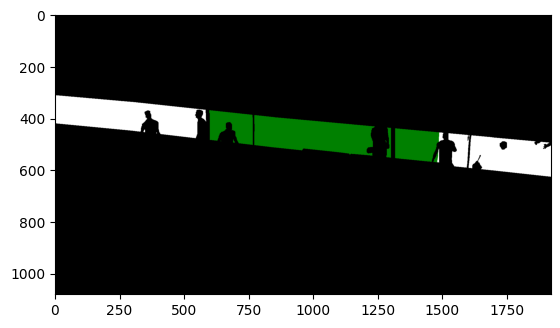

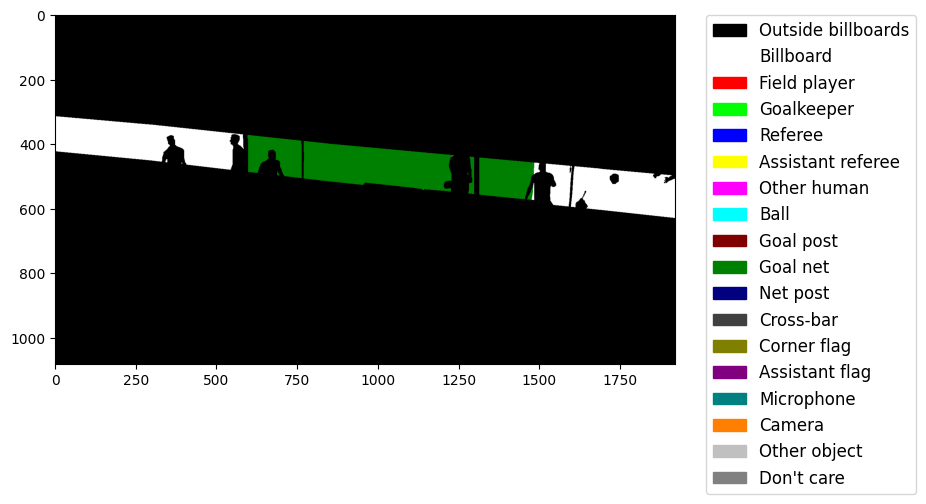

In [4]:
# Convert the annotations to the new classes
import matplotlib.patches as mpatches

ann_path = os.path.join(data_root, ann_dir, 'Stadium_6_Match_1_in_1fps_6275.png')
img = Image.open(ann_path)
# print(img.size)
# img_np = np.array(img, dtype=np.uint8)
# print(img_np.shape)
# # If the pixel is not 1 or 9, change it to 0
# img_np = np.where((img_np == 1) | (img_np == 9), img_np, 0)
# img = Image.fromarray(img_np).convert('P')
# img.putpalette(np.array(old_palette, dtype=np.uint8))
plt.imshow(np.array(img.convert('RGB')))
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

patches = [mpatches.Patch(color=np.array(old_palette[i])/255., label=old_classes[i]) for i in range(len(old_classes))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='large')


plt.show()

In [ ]:
all_ann_files = os.listdir(os.path.join(data_root, ann_dir))

for file in tqdm(all_ann_files):
    # Open the image
    ann = Image.open(os.path.join(data_root, ann_dir, file))
    # Create a numpy array from the image
    ann_np = np.array(ann, dtype=np.uint8)
    # If the pixel is not 1 or 9, change it to 0
    ann_np = np.where((ann_np == 1) | (ann_np == 9), ann_np, 0)
    # Create the image from the numpy array
    seg_img = Image.fromarray(ann_np).convert('P')
    # Add the palette to the image
    seg_img.putpalette(np.array(old_palette, dtype=np.uint8))
    # Save the image
    seg_img.save(os.path.join(data_root, ann_dir, file))

In [ ]:
import os.path as osp

In [ ]:
# split train/val set randomly
split_dir = 'splits'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [ ]:
# Split the dataset in train, val and test set
# The file names always starts with the name of the stadium, e.g. 'Stadium_1_Match_1_in_1fps_0001.png'
# The files from the stadium 4 are used for the test set
# The files from the stadium 3 and 7 are used for the validation set
# The rest of the files are used for the training set

split_dir = 'splits'
mmengine.mkdir_or_exist(os.path.join(data_root, split_dir))
filename_list = [os.path.splitext(filename)[0] for filename in os.listdir(os.path.join(data_root, ann_dir))]
test_files = []
val_files = []
train_files = []
for file in filename_list:
    # Get the name of the stadium
    stadium_name = file.split('_')[1]
    # If the stadium is 4
    if stadium_name == '4':
        # Add the file to the test set
        test_files.append(file)
    # If the stadium is 3 or 7
    elif stadium_name == '3' or stadium_name == '7':
        # Add the file to the validation set
        val_files.append(file)
    # If the stadium is not 3, 4 or 7
    else:
        # Add the file to the training set
        train_files.append(file)

with open(os.path.join(data_root, split_dir, 'train.txt'), 'w') as f:
    f.writelines(line + '\n' for line in train_files)
with open(os.path.join(data_root, split_dir, 'val.txt'), 'w') as f:
    f.writelines(line + '\n' for line in val_files)
with open(os.path.join(data_root, split_dir, 'test.txt'), 'w') as f:
    f.writelines(line + '\n' for line in test_files)

After processing the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [3]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class SoccerNet(BaseSegDataset):
  METAINFO = dict(classes = old_classes, palette = old_palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)
    

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [ ]:
# Download config and checkpoint files
!mim download mmsegmentation --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest .

In [4]:
from mmengine import Config
cfg = Config.fromfile('../configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')
# print(f'Config:\n{cfg.pretty_text}')

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [5]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 3
cfg.model.auxiliary_head.num_classes = 3

# Modify dataset type and path
cfg.dataset_type = 'SoccerNet'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# Load the pretrained weights
cfg.load_from = 'pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.train_cfg.max_iters = 2000
cfg.train_cfg.val_interval = 200
cfg.default_hooks.logger.interval = 10
cfg.default_hooks.checkpoint.interval = 200

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    256,
    256,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'Dataset'
dataset_type = 'SoccerNet'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=200, type='CheckpointHook'),
    logger=dict(interval=10, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.75,
]
load_from = '

### Train and Evaluation

In [6]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

12/28 19:28:48 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce RTX 3090
    CUDA_HOME: /usr/local/cuda-12.2
    NVCC: Cuda compilation tools, release 12.2, V12.2.140
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.1.2
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60

/home/vgaspar/Documents/TFE/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/vgaspar/Documents/TFE/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/vgaspar/Documents/TFE/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


12/28 19:28:49 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
12/28 19:28:49 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/home/vgaspar/Documents/TFE/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [7]:
# start training
runner.train()

12/28 19:28:52 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
12/28 19:28:53 - mmengine - INFO - load model from: open-mmlab://resnet50_v1c
12/28 19:28:53 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet50_v1c
12/28 19:28:53 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

Loads checkpoint by local backend from path: pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([3]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape tor

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

Inference with trained model

/home/vgaspar/Documents/TFE/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/vgaspar/Documents/TFE/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: ./work_dirs/tutorial/iter_2000.pth


/home/vgaspar/miniconda3/envs/mmseg/lib/python3.11/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


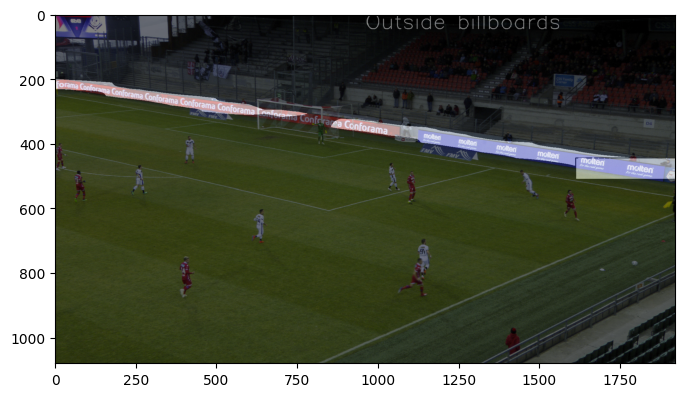

In [8]:
from mmseg.apis import init_model, inference_model, show_result_pyplot
import matplotlib.pyplot as plt
import os

# Init the model from the config and the checkpoint
checkpoint_path = './work_dirs/tutorial/iter_2000.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread(os.path.join(data_root, img_dir, 'Stadium_1_Match_1_in_1fps_0491.png'))
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))
